# Validation of bootstrapping

Here, we compare the true distribution of energies obtained from *ibmq_kolkata* versus the bootstrapped distrubitions to assess empirically whether it is motivated as a tecnique.

In [1]:
from qiskit.providers.ibmq.runtime import RuntimeDecoder
import numpy as np
import json
from postprocessing.zne_tools import get_energies
from symmer.symplectic import PauliwordOp

import os

qem_directory =  os.getcwd()
bs_data_dir = os.path.join(qem_directory, 'data/bootstrap_validation')
print(bs_data_dir)

with open(bs_data_dir+'/ibmq_kolkata_BS.json', 'r') as f:
    data_dict = json.load(f)

RD = RuntimeDecoder()
data_raw = RD.decode(data_dict['RAW'])

ham_cs_dict = {'III': (-453.09074243348186+0j), 'IIZ': (0.3938279139008882+0j), 'IZI': (0.6207540014723985+0j), 'IZZ': (0.8467205227384085+0j), 'ZII': (0.6207540014723985+0j), 'ZIZ': (0.8467205227384084+0j), 'ZZI': (0.2583692120830724+0j), 'ZZZ': (0.23804868510762295+0j), 'IIX': (-0.015457549840655714+0j), 'IZX': (0.015457549840655714-0j), 'ZIX': (0.015457549840655714+0j), 'ZZX': (-0.015457549840655714+0j), 'IXI': (0.004504380403727218+0j), 'IXZ': (-0.004504380403727218+0j), 'ZXI': (0.06195857194191802+0j), 'ZXZ': (-0.06195857194191802+0j), 'IXX': (-0.009644441995559343+0j), 'IYY': (-0.009644441995559343+0j), 'ZXX': (0.009644441995559343+0j), 'ZYY': (0.009644441995559343+0j), 'XII': (-0.004504380403727218+0j), 'XIZ': (0.004504380403727218+0j), 'XZI': (-0.06195857194191803+0j), 'XZZ': (0.061958571941918006+0j), 'XIX': (0.009644441995559343+0j), 'XZX': (-0.009644441995559343+0j), 'YIY': (0.009644441995559343-0j), 'YZY': (-0.009644441995559343+0j), 'YYI': (-0.05559874279713038+0j), 'YYZ': (0.05559874279713038+0j), 'XXX': (-0.03521948529328592+0j), 'XYY': (-0.03521948529328592+0j), 'YXY': (-0.03521948529328592+0j), 'YYX': (0.03521948529328592-0j)}

ham_cs = PauliwordOp.from_dictionary(ham_cs_dict)

/home/tweaving/qc-research/quantum-error-mitigation/data/bootstrap_validation


In [35]:
from symmer.symplectic import QuantumState
ham_diag = ham_cs[1:8]
#ham_diag.coeff_vec[0]=1
print(ham_diag)
bs_estimates = []
bs_variances = []

for i in range(len(data_raw['results']['experiment_data'])):
    key = f'0_{i}'
    counts = data_raw['results']['experiment_data'][key]['RAW'][0]
    psi_counts = QuantumState.from_dictionary(counts).normalize_counts

    resampled_energies=[]
    for i in range(50):
        psi_resample = psi_counts.sample_state(
            data_raw['results']['experiment_data'][key]['n_shots_by_circuit'][0]
        ).normalize_counts
        nrg_resample = psi_resample.dagger * ham_diag * psi_resample
        resampled_energies.append(nrg_resample)
    resampled_energies = np.asarray(resampled_energies)
    bs_estimates.append(np.mean(resampled_energies))
    bs_variances.append(np.var(resampled_energies))

bs_estimates= np.asarray(bs_estimates)
bs_variances= np.asarray(bs_variances)

 0.394+0.000j IIZ +
 0.621+0.000j IZI +
 0.847+0.000j IZZ +
 0.621+0.000j ZII +
 0.847+0.000j ZIZ +
 0.258+0.000j ZZI +
 0.238+0.000j ZZZ


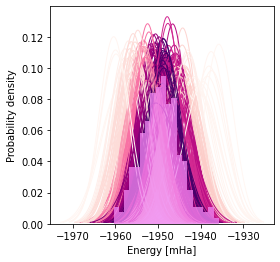

In [37]:
from matplotlib import pyplot as plt
import scipy.stats as stats

bs_stddevs = np.sqrt(bs_variances)
bs_energies = bs_estimates

n_bins = 20

fig, axis = plt.subplots(figsize=(4,4))

def gaussian(x, mu=0, sigma=1):
    return np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))

mask_non_outliers = abs(bs_energies - np.mean(bs_energies)) < 3*np.std(bs_energies)

freq, bins, _ = axis.hist(bs_energies[mask_non_outliers]*1e3, bins=n_bins, zorder=2, color='violet', alpha=0.8, density=True)
for mu, sigma in zip(bs_energies[mask_non_outliers], bs_stddevs[mask_non_outliers]):
    #mu = np.mean(bs_energies)
    mu*=1e3
    sigma*=1e3
    index = np.where(mu>=bins)[0][-1]
    if index==n_bins:
        index=-1
    alpha = (freq[index]/max(freq))**2
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    c = plt.colormaps.get('RdPu')(alpha)
    axis.plot(x, stats.norm.pdf(x, mu, sigma), lw=1, zorder=1, color=c)

axis.set_xlabel('Energy [mHa]')    
axis.set_ylabel('Probability density')

fig.savefig('plots/bootstrap_validation.png', dpi=300, bbox_inches='tight')
plt.show()

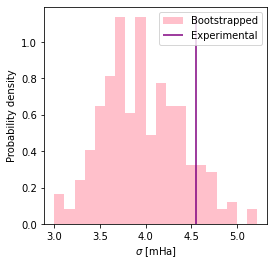

In [41]:
fig, axis = plt.subplots(figsize=(4,4))
freq, bins, _ = axis.hist(bs_stddevs[mask_non_outliers]*1e3, density=True, bins=20, label='Bootstrapped', color='pink')
axis.vlines(np.std(bs_energies[mask_non_outliers])*1e3,0,max(freq), label='Experimental', color='purple')
axis.legend()
axis.set_ylabel('Probability density')
axis.set_xlabel('$\\sigma$ [mHa]')
fig.savefig('plots/bootstrapped_sigmas.png', dpi=300, bbox_inches='tight')
plt.show()